<a href="https://colab.research.google.com/github/MatchLab-Imperial/deep-learning-course/blob/master/2020_07_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Representation Learning

In this tutorial we are going to show how to learn a good feature representation for MNIST images. In this case, however, we will not use the labels available in the dataset to learn a label predictor $g$. We will approach the problem in an unsupervised manner by using the autoencoder method explained in the lecture. Hence, given an image $x$ from MNIST, we will encode it (using an encoder $\phi$) to a lower dimensionality vector $\phi(x)$, for example using only 2 values. Then, we will decode the lower dimensionality vector using a decoder $\psi$, and then minimize a reconstruction error. In this tutorial, we will use the $l_2$-norm as reconstruction metric: we will minimize $||x - \psi(\phi(x))||^2$. The following figure from the slides summarizes the idea.

<a href="https://ibb.co/0hhQ3Zt"><img src="https://i.ibb.co/6ggN5bB/Screenshot-from-2019-02-14-14-49-24.png" alt="Screenshot-from-2019-02-14-14-49-24" border="0"></a>

**Loading the dataset**
As usual, we load the dataset and import some necessary modules. Both encoder $\phi$ and decoder $\psi$ will use `Dense` layers (with some activation functions in some cases), so we load the data in an array form in this tutorial. 

In [ ]:
import numpy as np
import keras
np.random.seed(123)  # for reproducibility
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from keras.datasets import mnist

num_classes = 10
# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1] * x_train.shape[2])
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1] * x_test.shape[2])

x_train= x_train.astype('float32')
x_test= x_test.astype('float32')

x_train /= 255.
x_test /= 255.


## Linear autoencoder
In our first approach we will not use any activation function, the model is completely linear. We encode the input flattened image of dimensionality $784$ ($28\times28$) in a vector of 2 dimensions, and then decode it back to the $784$ vector. To do so, we first design a linear model using `Sequential()` and a couple of `Dense` layers. Notice how we can give a name to a layer by using the `name` argument. In this case, we give the name `representation` to the layer that encodes the input vector in only two dimensions. If you design your own network in this tutorial, you should use the `name=representation` argument as we will use it to retrieve the representation vectors $\phi(x)$ from any arbitrary input data $x$.

In [50]:
model = Sequential()
model.add(Dense(2, name='representation', input_shape=(28**2,)))
model.add(Dense(784))
model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mse'])
print(model.summary())
epochs = 10
validation_split = 0.1
history = model.fit(x_train, x_train, batch_size=128,
          epochs=epochs, validation_split=validation_split)


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
representation (Dense)       (None, 2)                 1570      
_________________________________________________________________
dense_16 (Dense)             (None, 784)               2352      
Total params: 3,922
Trainable params: 3,922
Non-trainable params: 0
_________________________________________________________________
None
Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 3s 56us/step - loss: 0.0652 - mean_squared_error: 0.0652 - val_loss: 0.0582 - val_mean_squared_error: 0.0582
Epoch 2/10
54000/54000 [==============================] - 2s 36us/step - loss: 0.0577 - mean_squared_error: 0.0577 - val_loss: 0.0576 - val_mean_squared_error: 0.0576
Epoch 3/10
54000/54000 [==============================] - 2s 37us/step - loss: 0.0573 - mean_squared_error: 0.0573 - val_loss:

Now, we will see if we have learnt a good representation of the images by using this linear autoencoder. First, let's check the MSE in the test set.



In [51]:
# Evaluates model in the given metric (MSE in this case)
print('Test MSE obtained is {:.4f}'.format(model.evaluate(x_test, x_test)[0]))

10000/10000 [==============================] - 1s 55us/step
Test MSE obtained is 0.0557


We have an MSE of around 0.056 in the test set. It may be hard to know if this value means a good reconstruction or not, but it can help us to compare to other models. To have a better understanding of what this value means qualitatively, let's plot some images, along with the corresponding MSE.

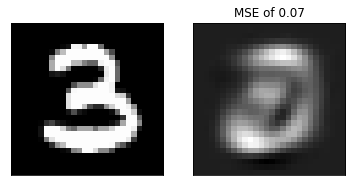

In [52]:
def plot_recons_original(image, label):
  ## Function used to plot image x and reconstructed image \psi\phi(x)
  # Reshape (just in case) and predict using model
  if len(image.shape) == 1:
    image = image.reshape(1, -1)
  reconst_image = model.predict(image)
  # Evaluate MSE to also report it in the image
  mse = model.evaluate(image, image, verbose=0)
  # Create a figure with 1 row and 2 columns
  plt.subplots(1,2)
  # Select first image in the figure
  ax = plt.subplot(121)
  # Plot image x
  plt.imshow(image.reshape(28,28), cmap='gray')
  # This removes the ticks in the axis
  ax.set_xticks([])
  ax.set_yticks([])
  # Select second image in the figure
  ax = plt.subplot(122)
  # Plot reconstructed image
  plt.imshow(reconst_image.reshape(28,28), cmap='gray')
  # This removes the ticks in the axis
  ax.set_xticks([])
  ax.set_yticks([])
  # Set a title to the current axis (second figure)
  plt.title('MSE of {:.2f}'.format(mse[0]))
  plt.show()

# Select a random index from the test set
ind = np.random.randint(x_test.shape[0] -  1)
plot_recons_original(x_test[ind], y_test[ind])

We see how the reconstructed images look in most cases blurry, due to the autoencoder $\psi(\phi(x))$ not having enough representation capacity. In Task 1, you will try to improve the model by adding some non-linearities/more layers. Now, let's check how the feature vectors are distributed in the representation space.

## Representation space
If we have a good representation, we hope to see in the representation space clusters of similar points in the image space. For example, images from the same class should be close to each other.

To check how the features are distributed in the representation space, we forward the images from the test set to the autoencoder and retrieve the representation $\phi(x)$ in the layer with `name='representation'`. As the vector only has dimensionality 2 (we used `Dense(2...)`), we do not need to apply any dimensionality reduction technique such as PCA to plot it.

We first compute the representation of the images from the MNIST test set using the `predict_representation` function. The function uses the name we gave to the layer to retrieve the representation vector, it forms a new model that instead of doing $\psi(\phi(x))$ it only computes $\phi(x)$.

In [ ]:
def predict_representation(model, data, layer_name='representation'):
  ## We form a new model. Instead of doing \psi\phi(x), we only take \phi(x)
  ## To do so, we use the layer name
  intermediate_layer_model = Model(inputs=model.input,
                                   outputs=model.get_layer(layer_name).output)
  representation = intermediate_layer_model.predict(data)
  representation = representation.reshape(representation.shape[0], -1)
  return representation

representation = predict_representation(model, x_test)

Now, we plot the computed representation for the test images in a 2D scatter plot. We also use in the scatter plot the corresponding label by assigning different colours to the labels.

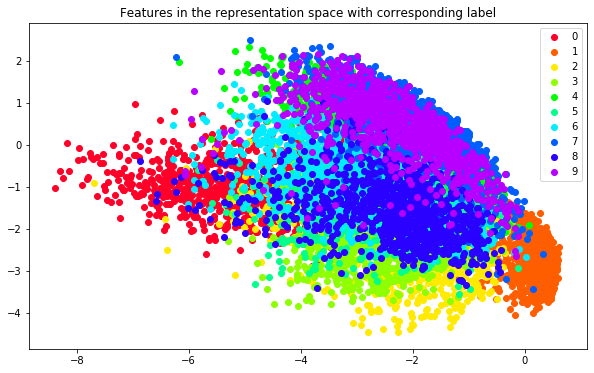

(<Figure size 720x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f22f3440e48>)

In [54]:
def plot_representation_label(representation, labels, plot3d=0):
  ## Function used to plot the representation vectors and assign different 
  ## colors to the different classes

  # First create the figure
  fig, ax = plt.subplots(figsize=(10,6))
  # In case representation dimension is 3, we can plot in a 3d projection too
  if plot3d:
    ax = fig.add_subplot(111, projection='3d')
    
  # Check number of labels to separate by colors
  n_labels = labels.max() + 1
  # Color map, and give different colors to every label
  cm = plt.get_cmap('gist_rainbow')
  ax.set_prop_cycle(color=[cm(1.*i/(n_labels)) for i in range(n_labels)])
  # Loop is to plot different color for each label
  for l in range(n_labels):
    # Only select indices for corresponding label
    ind = labels == l
    if plot3d:
      ax.scatter(representation[ind, 0], representation[ind, 1], 
                 representation[ind, 2], label=str(l))
    else:
      ax.scatter(representation[ind, 0], representation[ind, 1], label=str(l))
  ax.legend()
  plt.title('Features in the representation space with corresponding label')
  plt.show()
  return fig, ax

plot_representation_label(representation, y_test)

The representation of the images from the same class are close to each other (each colour is a different digit). However, some of the classes seem to overlap with each other, and some classes are more clustered than others. For example, the class `1`is well clustered, but the class `9` seems to overlap greatly with the class `7`.  The class `8` is also quite spread out, with some of the features closer to the features of the class `1`, some others closer to the class `0` and so on.

## Clustering the data
We have learnt a representation, and we also plotted it in the last section. We saw how the representations for the different images from the same label were close to each other without actually using the label information in the training process. Now, let's do a quick experiment to see how well clustered are the features. We will use a clustering method on these features, and then assign each of the clusters to the majority class (most represented class in the cluster). We want to check what kind of accuracy we would have using this simple classification method as a way to understand how well clustered they are.

First, let's now cluster the features using a standard technique called K-Means. A good guess is to use the same number of clusters as classes, in this case 10. Then, as we mentioned, assign each of the clusters to the majority class. And then we compute the accuracy of this method.

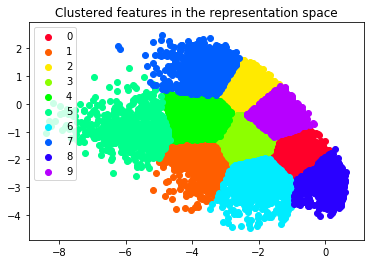

Accuracy of 0.399


In [7]:
def cluster_plot_data(representation):
  from sklearn.cluster import KMeans
  # Set number of clusters to 10
  n_clusters = 10
  # Use KMeans
  c_pred = KMeans(n_clusters=n_clusters).fit_predict(representation)
  _, ax = plt.subplots(1,1)
  # Color map, and give different colors to every label
  cm = plt.get_cmap('gist_rainbow')
  ax.set_prop_cycle(color=[cm(1.*i/(n_clusters)) for i in range(n_clusters)])
  # Loop is to plot different color for each label
  for c in range(n_clusters):
    # Only select indices for corresponding label
    ind = c_pred == c
    ax.scatter(representation[ind, 0], representation[ind, 1], label=str(c))
  ax.legend()
  plt.title('Clustered features in the representation space')
  plt.show()
  return c_pred

c_pred = cluster_plot_data(representation)

# Compute accuracy by checking cluster by cluster the majority class and
# assigning all of the data points in that cluster to the majority class
# Then we check the accuracy of doing so
correct = 0
for i in range(10):
  indices_c_pred = c_pred == i
  classes = y_test[indices_c_pred]
  counts = np.bincount(classes)
  class_max = np.argmax(counts)
  correct += (classes == class_max).sum()
  
print('Accuracy of {:.3f}'.format(correct/(1.0*y_test.shape[0])))

Even though it is not a good way to classify the samples compared to the supervised case that you have done in past tutorials, the accuracy is still quite higher than random guess, which would be around ~10%.

## Relationship to PCA

In the lecture session, it was mentioned that a linear autoencoder has a relationship with PCA, i.e. using an autoencoder with representation dimensionality of $d$ was equivalent to finding the first $d$ principal components. Let's test it by computing the PCA of the train set, and applying it in the test set. Then we will check the representation space plot, and the reconstruction MSE and check if they are consistent with what we obtained with the autoencoder.

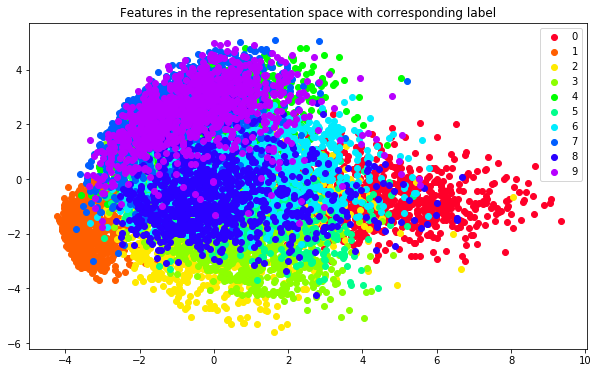

In [8]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca = pca.fit(x_train)
representation_pca = pca.transform(x_test)
plot_representation_label(representation_pca, y_test)
plt.show()

The resulting figure for PCA is similar to the one obtained in the linear autoencoder section, being the main difference that this one is mirrored. 

We now check if the given MSE in the test set is similar to the linear autoencoder we trained before.

In [9]:
reconst_test = pca.inverse_transform(representation_pca)
mse_pca = ((reconst_test - x_test)**2).mean()

print('Test MSE for PCA is {:.4f}'.format(mse_pca))

Test MSE for PCA is 0.0557


The reconstruction error we get is almost the same as the one obtained with the autoencoder case, with only a small variation, the variation due to the stochastic training in the autoencoder case. This validates the claim that a linear autoencoder acts similar to a PCA.

## Detecting anomalies

After checking the representation of the MNIST images, let's focus on how to spot anomalies in the data, which are samples that deviate from the usual distribution. In the lecture it has been mentioned how when given a data point from another distribution, the reconstruction error will be higher. We now will test that. To do so, we will use the Extended MNIST (EMNIST) dataset, which apart from digits, includes also both lowercase and uppercase characters from a to z.

Let's start by downloading and loading the dataset. The following piece of code downloads the data and uncompresses some necessary files.

In [10]:
!wget http://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/gzip.zip -q
!unzip -qq ./gzip.zip
!mv gzip data
# We need to unzip a couple of files with the train
# labels and images 
!gunzip ./data/emnist-byclass-test-images-idx3-ubyte.gz 
!gunzip ./data/emnist-byclass-test-labels-idx1-ubyte.gz
# We also install a package to help us 
!pip install python-mnist

  Created wheel for python-mnist: filename=python_mnist-0.6-py2.py3-none-any.whl size=11660 sha256=dfb630053d360728c228a6405678bf77d7b68529267492dd9a8171804cd2230c
  Stored in directory: /root/.cache/pip/wheels/28/29/36/408f83545a511c43d03ef997a1dc99b49ccd5f9f306ed92468
Successfully built python-mnist


Now that we have downloaded the data, we will use the module `mnist` to load the images in the same format as the regular MNIST dataset included in Keras.

In [ ]:
from mnist import MNIST

# Images in folder data
mndata = MNIST('data')

# This will load the test data from the downloaded files
emnist_x_test, emnist_y_test = mndata.load('./data/emnist-byclass-test-images-idx3-ubyte',
                               './data/emnist-byclass-test-labels-idx1-ubyte')


# Convert data to numpy arrays and normalize images to the interval [0, 1]
n_elem = len(emnist_x_test)
emnist_x_test = np.array(emnist_x_test).reshape(n_elem,28,28).transpose(0,2,1).reshape(n_elem,28**2) / 255.0
emnist_y_test = np.array(emnist_y_test)

# Get labels mapping (index in emnist_y_test to character value)
emnist_labels = map(lambda x: x.strip('\r').split(' '), open('./data/emnist-byclass-mapping.txt').read().strip().split('\n'))
emnist_labels = dict(emnist_labels)

# This function will be useful to display the actual label, which is given as
# an ascii value (https://en.wikipedia.org/wiki/ASCII) instead of characters
def label_to_char(label):
  ascii_val = emnist_labels[str(label)]
  return chr(int(ascii_val))

Here we just plot a random image from the EMNIST dataset. Each time you run it, you get a random image from the dataset, in case you want to check how the different characters look.

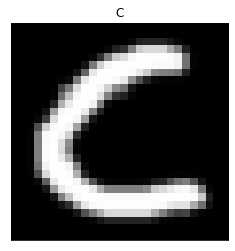

In [56]:
ind_plot = np.random.randint(emnist_x_test.shape[0]-1)
_, ax = plt.subplots(1,1)
plt.imshow(emnist_x_test[ind_plot].reshape(28, 28), cmap='gray')
ax.set_xticks([])
ax.set_yticks([])
# We use the label_to_char function to plot the actual character in the
# figure title
plt.title(label_to_char(emnist_y_test[ind_plot]))
plt.show()

Now we have loaded the EMNIST dataset. The images contain characters that the autoencoder has not seen before, hence the reconstruction error (we use Mean Squared Error as the reconstruction metric) for the EMNIST dataset should be higher. We will first compute the reconstruction error for the MNIST test data, and then compute the same for the EMNIST data. Then, we compare the distribution of reconstruction error in both sets using a histogram visualization.

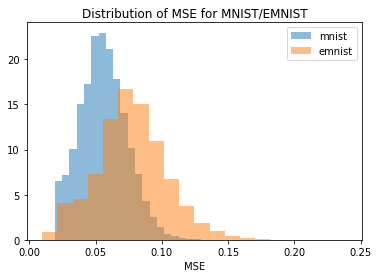

In [13]:
def compute_errors(model, mnist_data, emnist_data):
  ## This function plots the histogram of mse for a given model and two 
  ## datasets (assuming mnist and emnist in this case)
  ## The function also returns the mse per sample for both datasets and the
  ## reconstructed images for both datasets
  
  # Predict reconstructed images for mnist
  reconst_mnist = model.predict(mnist_data)
  # Reshape and compute mse per image
  reconst_mnist = reconst_mnist.reshape(reconst_mnist.shape[0], -1)
  mnist_data = mnist_data.reshape(mnist_data.shape[0], -1)
  mse_mnist = ((reconst_mnist - mnist_data)**2).mean(-1)
  # Plot histogram, with density=True we normalize so the area adds up to 1
  plt.hist(mse_mnist, bins=20, label='mnist', alpha=0.5, density=True)
  
  # Same for EMNIST, first predict reconstructed images
  reconst_emnist = model.predict(emnist_data)
  # Reshape and compute mse per image
  reconst_emnist = reconst_emnist.reshape(reconst_emnist.shape[0], -1)
  emnist_data = emnist_data.reshape(emnist_data.shape[0], -1)
  mse_emnist = ((reconst_emnist - emnist_data)**2).mean(-1)
  # Plot histogram
  plt.hist(mse_emnist, bins=20, label='emnist', alpha=0.5, density=True)
  # Title, label and legend
  plt.xlabel('MSE')
  plt.title('Distribution of MSE for MNIST/EMNIST')
  plt.legend()
  plt.show()
  return reconst_mnist, mse_mnist, reconst_emnist, mse_emnist

reconst_mnist, mse_mnist, reconst_emnist, mse_emnist = compute_errors(model, 
                                                                      x_test, 
                                                                      emnist_x_test)

As we expected, the distribution of errors for the EMNIST dataset has a higher mean and variance compared to the original MNIST. Let's now check how the image with the least reconstruction error and the image with the most reconstruction error look.

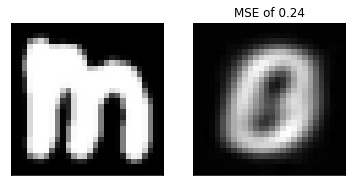

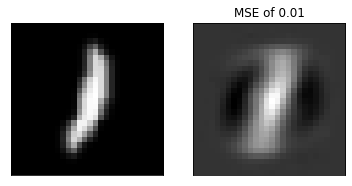

In [14]:
plot_recons_original(emnist_x_test[mse_emnist.argmax()], emnist_y_test[mse_emnist.argmax()])
plot_recons_original(emnist_x_test[mse_emnist.argmin()], emnist_y_test[mse_emnist.argmin()])

It looks like the model is not capable of representing images from EMNIST that differ in a great way to the MNIST images. However, it behaves well for images that are similar to those from MNIST, which is what we expected.

We now perform an anomaly detection exercise. We set the threshold $\tau$, which we use to mark a data point as an anomaly if $||x-\psi(\phi(x))||^2>\tau$, as $\tau = \mu + 2\sigma$, where $\mu$ is the average MSE for the whole MNIST test set, and $\sigma$ is the standard deviation of the MSE in the MNIST test set. We will now plot the ratio of data points marked as anomalies for each of the classes in both MNIST and EMNIST. Additionally, we also report the average MSE per class in both datasets. We expect to see that the MNIST anomalies are quite lower compared to the EMNIST dataset, as the model has been trained with MNIST data.

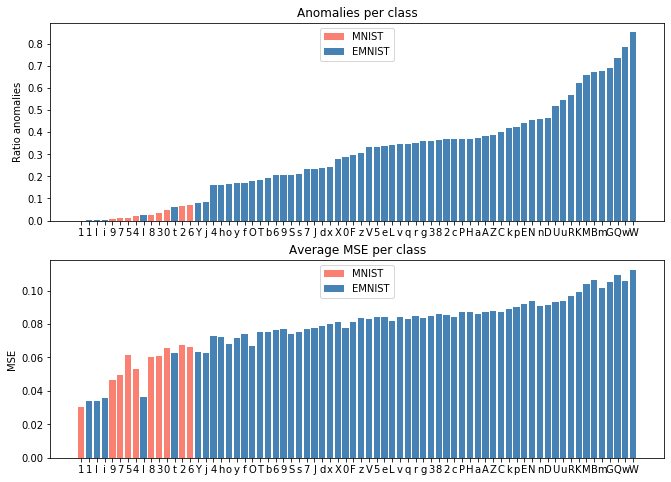

In [15]:
def print_mse_anomalies(mse_mnist, mse_emnist, emnist_labels, th=-1):
  ## This function uses the mse per class in both MNIST and EMNIST
  ## to compute the ratio of anomalies per class (anomalies/examples per class)
  ## We plot anomalies and mse in a bar histogram, ordered by ratio of anomalies
  ## Do not worry too much about how it works.
  
  # If no threshold (\tau) is given, we set it to \mu + 2\sigma
  if th == -1:
    th = 2*mse_mnist.std() + mse_mnist.mean()
  # MNIST labels are from 0-9
  mnist_labels = range(10)  
  
  # Initialize a list where we will save the 
  save_array = []
  
  # We start with MNIST
  for label in mnist_labels:
    # Indices with class == label
    indices_class = y_test == int(label)
    # Ratio of anomalies
    ratio_anom = (mse_mnist[indices_class] > th).sum()/(1.0*indices_class.sum())
    # Form an array with the mean mse in the class, the ratio of anomalies,
    # the corresponding label and a color which will use to plot this
    save_array.append([mse_mnist[indices_class].mean(), 
                       ratio_anom, str(label), 'salmon'])
  # Next is EMNIST
  for label in emnist_labels:
    indices_class = emnist_y_test == int(label)
    ratio_anom = (mse_emnist[indices_class] > th).sum()/(1.0*indices_class.sum())
    save_array.append([mse_emnist[indices_class].mean(), 
                       ratio_anom, label_to_char(label), 'steelblue'])
  
  # Number of total classes
  n_classes = len(save_array)    
  # We have a list of lists in distance_classes, we want to sort it by the 
  # ratio of anomalies, which is the index 1. To do so, we use sorted with
  # key=lambda x: x[1]
  save_array = sorted(save_array, key=lambda x: x[1])
  
  # Retrieve mse, anomalies, labels names and colors to plot from save_array
  mse_class = list(map(lambda x: x[0], save_array))
  anomalies_class = list(map(lambda x: x[1], save_array))
  labels_names = list(map(lambda x: x[2], save_array))
  colors = list(map(lambda x: x[3], save_array))
  
  # Plotting stuff
  plt.subplots(2,1, figsize=(11,8))
  plt.subplot(2,1,1)
  bars = plt.bar(range(n_classes), anomalies_class, color=colors)
  plt.xticks(range(n_classes), labels_names)
  plt.legend([bars[0],bars[-1]], ['MNIST', 'EMNIST'], loc='upper center')
  plt.title('Anomalies per class')
  plt.ylabel('Ratio anomalies')
  plt.subplot(2,1,2)
  plt.bar(range(n_classes), mse_class, color=colors)
  plt.xticks(range(n_classes), labels_names)
  plt.legend([bars[0],bars[-1]], ['MNIST', 'EMNIST'], loc='upper center')
  plt.title('Average MSE per class')
  plt.ylabel('MSE')
  plt.show()
print_mse_anomalies(mse_mnist, mse_emnist, emnist_labels)

The top figure shows the ratio of anomalies per class, which is the number of anomalies detected for the data points of that class divided by the number of examples of that specific class. The bottom figure shows the mean error per category, where we can see that the classes from EMNIST have a higher reconstruction error than those from MNIST. Even the same classes, the digits 0-9, have a different distribution as we can see how the error in EMNIST is higher for the same class. Additionally, some easy letters that look like the number 1 (`l, I, i, t, j`) or like 0 (`O` and `o`) have a low reconstruction error as they are similar to some classes in the MNIST dataset. Some other classes, such as `W`, `w`, or `Q` have a high reconstruction error due to being quite dissimilar to any of the images in MNIST.

We have seen that data from other datasets will have a high MSE. However, even for MNIST, we can look for samples that have a high reconstruction error compared to the mean. In the same class, there will be differences, which are called intra-class differences. We expect to see that several images will follow a similar distribution, however some of them will deviate from this distribution 

Now, let's take one of the classes from MNIST and plot some images with high reconstruction error and some others with low reconstruction error. We expect to see those with low reconstruction error to be quite similar between them and represent what the average sample of that class looks like. The high reconstruction error samples will, in turn, contain some elements (pose, shape for example).


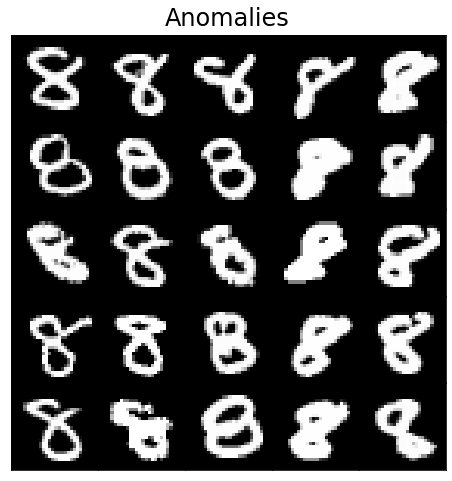

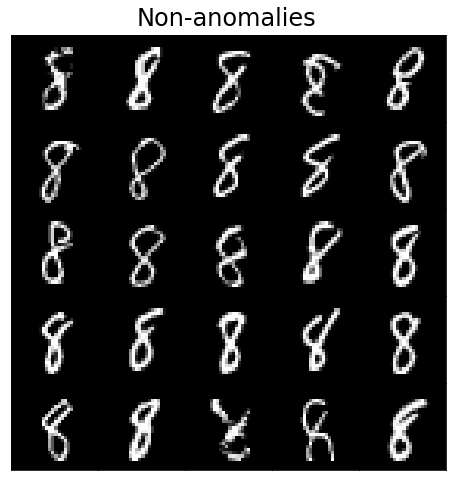

In [16]:
# Set same threshold we defined before \mu + 2\sigma
th = 2*mse_mnist.std() + mse_mnist.mean()

# We will use the label 8 for the example
indices_class = y_test == 8

# Compute the number of anomalies (mse > th)
anomalies_im = x_test[indices_class][mse_mnist[indices_class] > th]

# For the nonanomalies, we will sort the images by reconstruction error
# So we will plot the images with low reconstruction error
indices_sort = np.argsort(mse_mnist[indices_class])
nonanomalies_im = x_test[indices_class][indices_sort]

def plot_grid(images, N=5, title=''):
  ## Plots data in variable images in a grid of N*N
  # Create figure
  fig, axes = plt.subplots(N,N, figsize=(8,8))
  # Loop to generate grid
  for row in range(N):
    for col in range(N):
      idx = row+N*col
      axes[row,col].imshow(images[idx].reshape(28,28), cmap='gray')
      axes[row,col].set_xticks([])
      axes[row,col].set_yticks([])
  
  # Adjust white space
  fig.subplots_adjust(hspace=0.0)
  fig.subplots_adjust(wspace=0.0)
  fig.subplots_adjust(right=1.0)
  fig.subplots_adjust(left=0.245)
  # Set title
  fig.suptitle(title, x=0.62, y=0.93, fontsize=24)

# Plot anomalies
plot_grid(anomalies_im, title='Anomalies')
# Plot non-anomalies
plot_grid(nonanomalies_im, title='Non-anomalies')

The images that are anomalies (for the given threshold $\tau$) show a much larger variation in shape and pose. In turn, the images with low reconstruction error for the selected label (in this case `8`) show similar proportions and less variation between any two images.

# Dealing with Noise
An autoencoder aims to learn a function that reduces the dimensionality of the input data, only characterizing the most discriminative information of it.  As we have seen, autoencoders learn a representation of a set of data in an unsupervised manner, from which they will be able to generate a new representation as close as possible to the original input.

The idea is that they use the reconstruction error on input data as a form of *self-supervision*. Thus, they are trained to create a feature representation (encoding), and a decoding function to reconstruct the input data.

The dimensionality reduction/compression is widely used in many signal processing tasks. We will focus this part of the tutorial on using autoencoders to deal with noisy images, where autoencoders will learn to reconstruct only the characteristic information by avoiding the noise.

## Denoising Autoencoder

Ideally, we would like to capture only the key aspects presented in the data simply by ignoring the noise presented. The key idea behind is that noise is random, and it can not be predicted, a robust encoding/decoding will learn to identify the stable patterns within the image and avoid the non-smooth perturbations produced by the noise. 

This idea is in line with the **Efficient Coding Hypothesis** from the vision neuroscience field, which says ". . . the Efficient Coding Hypothesis holds that the purpose of early visual processing is to produce an efficient representation of the incoming visual signal."

Noise can be presented in many different ways, such as additive or multiplicative. In this tutorial, we will generate synthetically additive Gaussian noise to show you how to train a denoising autoencoder. 



In [17]:
import numpy as np
import keras
from keras.datasets import cifar100
from keras.utils import to_categorical

# Load the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.
x_test /= 255.

num_classes = 100
y_train=to_categorical(y_train,num_classes)
y_test=to_categorical(y_test,num_classes) 

# Add noise
x_train_noise = x_train + np.random.normal(size = x_train.shape, scale = 0.1)
x_test_noise = x_test + np.random.normal(size = x_test.shape, scale = 0.1)

169009152/169001437 [==============================] - 11s 0us/step


We can visualize some examples to have an idea of how the noise looks like:

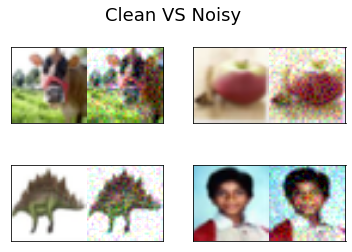

In [18]:
import matplotlib.pyplot as plt
from keras.layers import Lambda, Input
from keras.models import Model
import tensorflow as ktf

# Resize images for better visualization
inp = Input(shape=(32, 32, 3))
out = Lambda(lambda image: ktf.image.resize_images(image, (224, 224)))(inp)

model = Model(inputs=inp, outputs=out)
x_train_resized = model.predict(x_train[:4, ...])
x_train_noise_resized = model.predict(x_train_noise[:4, ...])

N=2
start_val = 0
fig, axes = plt.subplots(N,N)
plt.suptitle('Clean VS Noisy', fontsize=18)
for row in range(N):
  for col in range(N):
    idx = start_val+row+N*col
    
    im = np.concatenate((x_train_resized[idx], x_train_noise_resized[idx]), 1)
    axes[row,col].imshow(np.clip(im, 0, 1))
    axes[row,col].set_xticks([])
    axes[row,col].set_yticks([])

## Linear Autoencoders

As in regular architecture design, when defining the structure of an autoencoder, we can decide the number of convolutional layers, dense layers, normalization mechanisms, activation functions, and so on. 

Firstly, we will start with a simple linear architecture, similarly to the Representation Learning section, to show a straightforward case scenario, and then, we will build on top more complete and complex algorithms.

In [ ]:
from keras.layers import Dense, Reshape, Flatten
from keras.models import Sequential

model = Sequential()

## Encoder starts
model.add(Flatten())
model.add(Dense(128, input_shape=(32*32*3,)))
model.add(Dense(30))

## And now the decoder
model.add(Dense(128))
model.add(Dense(32*32*3))
model.add(Reshape((32, 32, 3)))

We will train our model with standard Mean Square Error (MSE) loss function. We will compute MSE between reconstructed images and noisy ones. Ideally, as mentioned above, the noise is random and therefore it will not be modeled, meaning that the architecture will only be able to reconstruct the structure of the input image, but avoiding the noise.

Sometimes we have noisy and clean images, and we can compute the MSE between the reconstructed and the clean ones. In this case, using clean ground-truth images improves results compared to only using noisy ones. However, we will start from the perspective of image compression and feature representation, and train our denoising model using exclusively noisy images.

In [20]:
model.compile(optimizer = 'Adam', loss = 'mean_squared_error', metrics = ['mse'])
model.fit(x_train_noise, x_train_noise, batch_size=128, epochs=10, validation_split=0.1)

Train on 45000 samples, validate on 5000 samples
Epoch 1/10
45000/45000 [==============================] - 3s 70us/step - loss: 0.0474 - mean_squared_error: 0.0474 - val_loss: 0.0298 - val_mean_squared_error: 0.0298
Epoch 2/10
45000/45000 [==============================] - 3s 63us/step - loss: 0.0270 - mean_squared_error: 0.0270 - val_loss: 0.0255 - val_mean_squared_error: 0.0255
Epoch 3/10
45000/45000 [==============================] - 3s 62us/step - loss: 0.0245 - mean_squared_error: 0.0245 - val_loss: 0.0241 - val_mean_squared_error: 0.0241
Epoch 4/10
45000/45000 [==============================] - 3s 62us/step - loss: 0.0238 - mean_squared_error: 0.0238 - val_loss: 0.0237 - val_mean_squared_error: 0.0237
Epoch 5/10
45000/45000 [==============================] - 3s 63us/step - loss: 0.0236 - mean_squared_error: 0.0236 - val_loss: 0.0236 - val_mean_squared_error: 0.0236
Epoch 6/10
45000/45000 [==============================] - 3s 63us/step - loss: 0.0235 - mean_squared_error: 0.0235 -

Let's check how images look like after 10 epochs. Run the following code to see different examples:

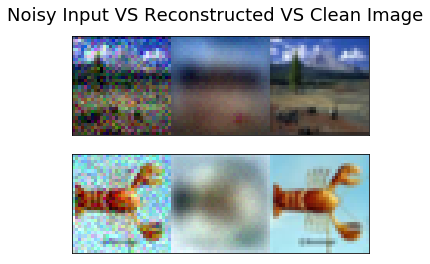

In [21]:
idx_example = np.random.randint(0, len(x_test_noise))
x_test_denoised = model.predict(x_test_noise[idx_example:idx_example+2, ...])

N=2
start_val = 0
fig, axes = plt.subplots(N,1)
plt.suptitle('Noisy Input VS Reconstructed VS Clean Image', fontsize=18)
for row in range(N):
  for col in range(1):
    idx = start_val+row+N*col
    
    im = np.concatenate((x_test_noise[idx_example+idx], x_test_denoised[idx], x_test[idx_example+idx]), 1)
    axes[row].imshow(np.clip(im, 0, 1))
    axes[row].set_xticks([])
    axes[row].set_yticks([])

Reconstructed images are a blurred version of the clean ones. The proposed autoencoder can learn to remove noise, but results are far from being perfect when comparing with the ground-truth images. However, it is promising that with a few neurons, the network can generate images that have roughly the same color and shape than original ones.

## Non-linear Autoencoders

In non-linear autoencoders, we introduce non-linearities within the network by using non-linear activation functions. This is a big difference with classical technique PCA, which performs a linear transformation of the data. Therefore, by using non-linear autoencoders we can create flexible algorithms that can learn features/relationships in the data beyond linear transformations. 

Now, we will check if adding a non-linear activation function brings any improvement: 

In [22]:
from keras.layers import Activation

nonlinear_model = Sequential()

## Encoder starts
nonlinear_model.add(Flatten())
nonlinear_model.add(Dense(128, input_shape=(32*32*3,)))
nonlinear_model.add(Dense(30))

## And now the decoder
nonlinear_model.add(Dense(128))
nonlinear_model.add(Dense(32*32*3, activation='sigmoid'))
nonlinear_model.add(Reshape((32, 32, 3)))

nonlinear_model.compile(optimizer = 'Adam', loss = 'mean_squared_error', metrics = ['mse'])
nonlinear_model.fit(x_train_noise, x_train_noise, batch_size=128, epochs=10, validation_split=0.1)

Train on 45000 samples, validate on 5000 samples
Epoch 1/10
45000/45000 [==============================] - 3s 70us/step - loss: 0.0428 - mean_squared_error: 0.0428 - val_loss: 0.0267 - val_mean_squared_error: 0.0267
Epoch 2/10
45000/45000 [==============================] - 3s 62us/step - loss: 0.0250 - mean_squared_error: 0.0250 - val_loss: 0.0242 - val_mean_squared_error: 0.0242
Epoch 3/10
45000/45000 [==============================] - 3s 61us/step - loss: 0.0237 - mean_squared_error: 0.0237 - val_loss: 0.0236 - val_mean_squared_error: 0.0236
Epoch 4/10
45000/45000 [==============================] - 3s 63us/step - loss: 0.0234 - mean_squared_error: 0.0234 - val_loss: 0.0235 - val_mean_squared_error: 0.0235
Epoch 5/10
45000/45000 [==============================] - 3s 62us/step - loss: 0.0233 - mean_squared_error: 0.0233 - val_loss: 0.0234 - val_mean_squared_error: 0.0234
Epoch 6/10
45000/45000 [==============================] - 3s 60us/step - loss: 0.0233 - mean_squared_error: 0.0233 -

We can now visualize the reconstructed images by the proposed non-linear model. 

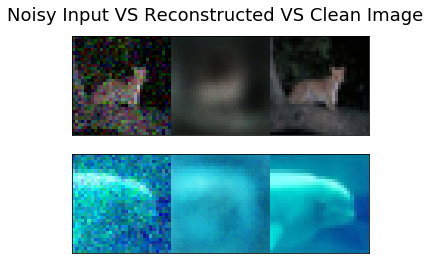

In [23]:
idx_example = np.random.randint(0, len(x_test_noise))
x_test_denoised = nonlinear_model.predict(x_test_noise[idx_example:idx_example+2, ...])

N=2
start_val = 0
fig, axes = plt.subplots(N,1)
plt.suptitle('Noisy Input VS Reconstructed VS Clean Image', fontsize=18)
for row in range(N):
  for col in range(1):
    idx = start_val+row+N*col
    
    im = np.concatenate((x_test_noise[idx_example+idx], x_test_denoised[idx], x_test[idx_example+idx]), 1)
    axes[row].imshow(np.clip(im, 0, 1))
    axes[row].set_xticks([])
    axes[row].set_yticks([])

Comparing qualitatively results at this stage is hard, therefore, we can compute the MSE metric in the test set for both architectures:

In [24]:
mse_linear, _ = model.evaluate(x_test_noise, x_test)
mse_nonlinear, _ = nonlinear_model.evaluate(x_test_noise, x_test)

print('MSE Linear Model:', mse_linear)
print('MSE Non-linear Model:', mse_nonlinear)

10000/10000 [==============================] - 1s 83us/step
MSE Linear Model: 0.01494256300330162
MSE Non-linear Model: 0.013948956954479218


Although results are close, we can observe an improvement in MSE just by applying a non-linear activation function to the network.

## Convolutional Autoencoders

As seen in previous tutorials, 2D convolutions are more suitable when the input is an image than 1D convolutions. In practical settings, convolutional autoencoders are always applied to images, they simply perform much better. 

CNNs are used exactly as before, however, now we have to take into account elements such as strides, pooling, upsampling, deconvolutions, which are needed to control the size (width and length) of the generated feature maps. A regular setting in image denoising is that the input and output dimension is constant.

Besides, we need to define the number of levels of compression within the architecture, which can be controlled by limiting the number of convolutional layers and/or downsampling steps:


![](https://i.ibb.co/vB2jq4C/autoencoders.png)

Let's define the architecture with 3 levels of compression:


In [25]:
from keras.layers import UpSampling2D, Conv2D

CNN_model = Sequential()

## Encoder starts
CNN_model.add(Conv2D(filters=32, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu'))
CNN_model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu'))
CNN_model.add(Conv2D(filters=128, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu'))

# At this point the dimension of the feature map is (batch_size, 4, 4, 128)

## And now the decoder
CNN_model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
CNN_model.add(UpSampling2D((2, 2)))
CNN_model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
CNN_model.add(UpSampling2D((2, 2)))
CNN_model.add(Conv2D(filters=3, kernel_size=(3,3), padding='same', activation='relu'))
CNN_model.add(UpSampling2D((2, 2)))

# Improve smoothness of the image:
CNN_model.add(Conv2D(filters=3, kernel_size=(3,3), padding='same', activation='relu'))

CNN_model.compile(optimizer = 'Adam', loss = 'mean_squared_error', metrics = ['mse'])
CNN_model.fit(x_train_noise, x_train_noise, batch_size=128, epochs=10, validation_split=0.1)


Train on 45000 samples, validate on 5000 samples
Epoch 1/10
45000/45000 [==============================] - 9s 202us/step - loss: 0.0459 - mean_squared_error: 0.0459 - val_loss: 0.0229 - val_mean_squared_error: 0.0229
Epoch 2/10
45000/45000 [==============================] - 4s 85us/step - loss: 0.0206 - mean_squared_error: 0.0206 - val_loss: 0.0188 - val_mean_squared_error: 0.0188
Epoch 3/10
45000/45000 [==============================] - 4s 83us/step - loss: 0.0183 - mean_squared_error: 0.0183 - val_loss: 0.0174 - val_mean_squared_error: 0.0174
Epoch 4/10
45000/45000 [==============================] - 4s 84us/step - loss: 0.0171 - mean_squared_error: 0.0171 - val_loss: 0.0164 - val_mean_squared_error: 0.0164
Epoch 5/10
45000/45000 [==============================] - 4s 84us/step - loss: 0.0163 - mean_squared_error: 0.0163 - val_loss: 0.0161 - val_mean_squared_error: 0.0161
Epoch 6/10
45000/45000 [==============================] - 4s 84us/step - loss: 0.0160 - mean_squared_error: 0.0160

In our example, we used in the encoder part strides of (2, 2), which will downsample the dimension of the feature map by 2 at every step. While in the decoder, we use UpSampling2D layers to increase at each level the feature's dimension by 2. This two mechanism allows us to control the dimensions of the feature maps. 

Let's check how reconstructed images look:

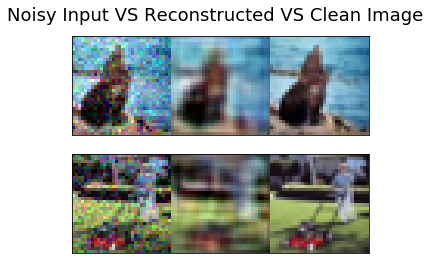

In [26]:
idx_example = np.random.randint(0, len(x_test_noise))
x_test_denoised = CNN_model.predict(x_test_noise[idx_example:idx_example+2, ...])

N=2
start_val = 0 
fig, axes = plt.subplots(N,1)
plt.suptitle('Noisy Input VS Reconstructed VS Clean Image', fontsize=18)
for row in range(N):
  for col in range(1):
    idx = start_val+row+N*col
    
    im = np.concatenate((x_test_noise[idx_example+idx], x_test_denoised[idx], x_test[idx_example+idx]), 1)
    axes[row].imshow(np.clip(im, 0, 1))
    axes[row].set_xticks([])
    axes[row].set_yticks([])

## Denoising with Clean Images

Autoencoders have been used for cleaning images, as they can encode the image's structure and recover the image while ignoring the non-smooth perturbations produced by the noise. So far, we have presented a self-supervised manner to train an autoencoder, since the loss function is computed between the reconstructed image and the noisy one. 

Although having a ground-truth of clean images is not always possible, it is desirable when training denoising models as it leads to better performance. Many people have been working on generating datasets with clean and noisy paired images to train better denoising models. 

As we have generated synthetically the noise, we can train the network using the original image as the clean one:

In [27]:
CNN_gt_model = Sequential()

## Encoder starts
CNN_gt_model.add(Conv2D(filters=32, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu'))
CNN_gt_model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu'))
CNN_gt_model.add(Conv2D(filters=128, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu'))

# At this point the dimension of the feature map is (batch_size, 4, 4, 128)

## And now the decoder
CNN_gt_model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
CNN_gt_model.add(UpSampling2D((2, 2)))
CNN_gt_model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
CNN_gt_model.add(UpSampling2D((2, 2)))
CNN_gt_model.add(Conv2D(filters=3, kernel_size=(3,3), padding='same', activation='relu'))
CNN_gt_model.add(UpSampling2D((2, 2)))

# Improve smoothness of the image:
CNN_gt_model.add(Conv2D(filters=3, kernel_size=(3,3), padding='same', activation='relu'))

CNN_gt_model.compile(optimizer = 'Adam', loss = 'mean_squared_error', metrics = ['mse'])
CNN_gt_model.fit(x_train_noise, x_train, batch_size=128, epochs=10, validation_split=0.1)

Train on 45000 samples, validate on 5000 samples
Epoch 1/10
45000/45000 [==============================] - 5s 103us/step - loss: 0.0431 - mean_squared_error: 0.0431 - val_loss: 0.0173 - val_mean_squared_error: 0.0173
Epoch 2/10
45000/45000 [==============================] - 4s 87us/step - loss: 0.0138 - mean_squared_error: 0.0138 - val_loss: 0.0114 - val_mean_squared_error: 0.0114
Epoch 3/10
45000/45000 [==============================] - 4s 88us/step - loss: 0.0107 - mean_squared_error: 0.0107 - val_loss: 0.0097 - val_mean_squared_error: 0.0097
Epoch 4/10
45000/45000 [==============================] - 4s 90us/step - loss: 0.0094 - mean_squared_error: 0.0094 - val_loss: 0.0086 - val_mean_squared_error: 0.0086
Epoch 5/10
45000/45000 [==============================] - 4s 90us/step - loss: 0.0087 - mean_squared_error: 0.0087 - val_loss: 0.0086 - val_mean_squared_error: 0.0086
Epoch 6/10
45000/45000 [==============================] - 4s 89us/step - loss: 0.0082 - mean_squared_error: 0.0082 

Let's now check how reconstructed images look:

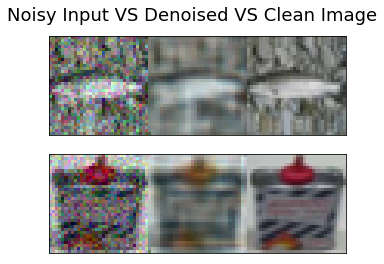

In [28]:
idx_example = np.random.randint(0, len(x_test_noise))
x_test_denoised = CNN_gt_model.predict(x_test_noise[idx_example:idx_example+2, ...])

N=2
start_val = 0 
fig, axes = plt.subplots(N,1)
plt.suptitle('Noisy Input VS Denoised VS Clean Image', fontsize=18)
for row in range(N):
  for col in range(1):
    idx = start_val+row+N*col
    
    im = np.concatenate((x_test_noise[idx_example+idx], x_test_denoised[idx], x_test[idx_example+idx]), 1)
    axes[row].imshow(np.clip(im, 0, 1))
    axes[row].set_xticks([])
    axes[row].set_yticks([])

In addition, we can compare the MSE when having clean images for training or not:

In [29]:
mse_selfsupervised, _ = CNN_model.evaluate(x_test_noise, x_test)
mse_supervised, _ = CNN_gt_model.evaluate(x_test_noise, x_test)

print('MSE "Self"-supervised Model. Trained only with Noisy Images: ', mse_selfsupervised)
print('MSE Supervised Model. Trained also with Clean Images: ', mse_supervised)

10000/10000 [==============================] - 1s 97us/step
MSE "Self"-supervised Model. Trained only with Noisy Images:  0.005552526880800724
MSE Supervised Model. Trained also with Clean Images:  0.006771531142294407


At this point, results do not differ that much. Model's complexity is not enough to reconstruct properly the image, and then having the clean image does not have a big impact. However, when using more complex models, which are able to recover the image, the fact that we can use clean images for training will help us to obtain much higher quality denoised images.

Skip connections, as the name suggests, creates connections between layers within the neural network by jumping some of them. This connection allows the network to feed layers not only with the previous one but, in addition, with other layers that were not directly connected. For example, in the next figure we can see a skip architecture, where encoder and decoder share features through skip connections:

![texto alternativo](https://i.ibb.co/d7sX5bh/Skip-Connections.png)

The idea behind this is that there is information in the first layers that is hard to recover by posterior ones. This information is important when upsampling the feature map in the decoder, where instead of learning how to recover features from the first layers, we can feed directly the information belonging to the encoder part in the decoder without the need of generating it. 

In addition, skip connections help to pass information through the network, helping to mitigate the vanishing gradient problem when the architecture is deep. As seen in CNN Architectures tutorial, gradient information can be lost during the backpropagation when it goes through many layers, and having a direct path between encoder and decoder layers helps the convergence and training of the network.

There are many ways to implement those skip connections, we show in the next example how to generate them by concatenating features:

In [ ]:
from keras.layers import Input, concatenate 
from keras.models import Model

def define_skip_model():
  
  input_net = Input((32,32,3))
  
  ## Encoder starts
  conv1 = Conv2D(32, 3, strides=(2,2), activation = 'relu', padding = 'same')(input_net)
  conv2 = Conv2D(64, 3, strides=(2,2), activation = 'relu', padding = 'same')(conv1)
  conv3 = Conv2D(128, 3, strides=(2,2), activation = 'relu', padding = 'same')(conv2)
  
  conv4 = Conv2D(128, 3, strides=(2,2), activation = 'relu', padding = 'same')(conv3)
  
  ## And now the decoder
  up1 = Conv2D(128, 3, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(conv4))
  merge1 = concatenate([conv3,up1], axis = 3)
  up2 = Conv2D(64, 3, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(merge1))
  merge2 = concatenate([conv2,up2], axis = 3)
  up3 = Conv2D(32, 3, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(merge2))
  merge3 = concatenate([conv1,up3], axis = 3)
  
  up4 = Conv2D(32, 3, padding = 'same')(UpSampling2D(size = (2,2))(merge3))
  
  output_net = Conv2D(3, 3, padding = 'same')(up4)
  
  model = Model(inputs = input_net, outputs = output_net)
  
  return model

Let's train the skip model:

In [31]:
skip_model = define_skip_model()
skip_model.compile(optimizer = 'Adam', loss = 'mean_squared_error', metrics = ['mse'])
skip_model.fit(x_train_noise, x_train, batch_size=128, epochs=10, validation_split=0.1)

_, mse = skip_model.evaluate(x_test_noise, x_test)

print('Skip Model MSE: ', mse)

Train on 45000 samples, validate on 5000 samples
Epoch 1/10
45000/45000 [==============================] - 8s 169us/step - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 2/10
45000/45000 [==============================] - 6s 142us/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 3/10
45000/45000 [==============================] - 6s 141us/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 4/10
45000/45000 [==============================] - 6s 141us/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 5/10
45000/45000 [==============================] - 6s 142us/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 6/10
45000/45000 [==============================] - 6s 142us/step - loss: 0.0021 - mean_squared_error: 0.

Let's visualize how the denoised images look:

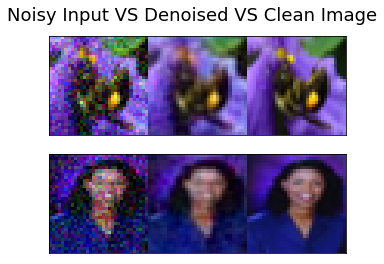

In [32]:
idx_example = np.random.randint(0, len(x_test_noise))
x_test_denoised = skip_model.predict(x_test_noise[idx_example:idx_example+2, ...])

N=2
start_val = 0 
fig, axes = plt.subplots(N,1)
plt.suptitle('Noisy Input VS Denoised VS Clean Image', fontsize=18)
for row in range(N):
  for col in range(1):
    idx = start_val+row+N*col
    
    im = np.concatenate((x_test_noise[idx_example+idx], x_test_denoised[idx], x_test[idx_example+idx]), 1)
    axes[row].imshow(np.clip(im, 0, 1))
    axes[row].set_xticks([])
    axes[row].set_yticks([])

Images are a bit blurry, but noise is almost all gone! 

## UNet Architecture

UNet is an autoencoder architecture with skip connections between encoder and decoder. It is a widely used architecture in the computer vision community for image translation tasks due to its big capability and effective connections.

Let's define first of all the model:


In [33]:
from keras.layers import MaxPooling2D, Dropout

def UNet_model():
  
  inputs = Input((32,32,3))
  
  ## Encoder part
  conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
  drop4 = Dropout(rate=0.5)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

  conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
  drop5 = Dropout(rate=0.5)(conv5)

  ## Now the decoder starts
  up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
  merge6 = concatenate([drop4,up6], axis = 3)
  conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)

  up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)

  up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)

  up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
  conv10 = Conv2D(3, 3,  padding = 'same')(conv9)

  model = Model(inputs = inputs, outputs = conv10)
  
  return model

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               393344    
_________________________________________________________________
dense_3 (Dense)              (None, 30)                3870      
_________________________________________________________________
dense_4 (Dense)              (None, 128)               3968      
_________________________________________________________________
dense_5 (Dense)              (None, 3072)              396288    
_________________________________________________________________
reshape_1 (Reshape)          (None, 32, 32, 3)         0         
Total params: 797,470
Trainable params: 797,470
Non-trainable params: 0
________________________________________________

Note that instead of using stride of 2 as done in previous architectures, UNet uses MaxPooling.

Let's train UNet model:

In [34]:
unet = UNet_model()
unet.compile(optimizer = 'Adam', loss = 'mean_absolute_error', metrics = ['mse'])
unet.fit(x_train_noise, x_train, batch_size=128, epochs=10, validation_split=0.1)

_, mse = unet.evaluate(x_test_noise, x_test)

print('UNet Model MSE: ', mse)




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 45000 samples, validate on 5000 samples
Epoch 1/10
45000/45000 [==============================] - 30s 669us/step - loss: 0.0599 - mean_squared_error: 0.0642 - val_loss: 0.0353 - val_mean_squared_error: 0.0021
Epoch 2/10
45000/45000 [==============================] - 26s 583us/step - loss: 0.0344 - mean_squared_error: 0.0020 - val_loss: 0.0329 - val_mean_squared_error: 0.0019
Epoch 3/10
45000/45000 [==============================] - 26s 585us/step - loss: 0.0328 - mean_squared_error: 0.0019 - val_loss: 0.0320 - val_mean_squared_error: 0.0018
Epoch 4/10
45000/45000 [==============================] - 26s 586us/step - loss: 0.0318 - mean_squared_error: 0.0018 - val_loss: 0.0317 - val_mean_squared_error: 0.0017
Epoch 5/10
45000/45000 [==============================] - 27s 591us/step - loss: 0.0313 - mean_squared_error: 0.0017 - val_loss: 0.0309 - val_mean_squared_er

Finally, we can visualize the final denoised images:

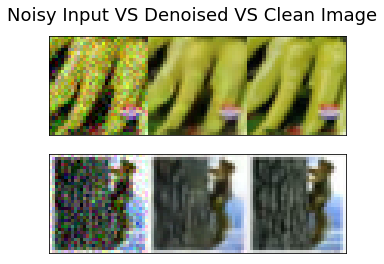

In [35]:
idx_example = np.random.randint(0, len(x_test_noise))
x_test_denoised = unet.predict(x_test_noise[idx_example:idx_example+2, ...])

N=2
start_val = 0 
fig, axes = plt.subplots(N,1)
plt.suptitle('Noisy Input VS Denoised VS Clean Image', fontsize=18)
for row in range(N):
  for col in range(1):
    idx = start_val+row+N*col
    
    im = np.concatenate((x_test_noise[idx_example+idx], x_test_denoised[idx], x_test[idx_example+idx]), 1)
    axes[row].imshow(np.clip(im, 0, 1))
    axes[row].set_xticks([])
    axes[row].set_yticks([])

# Coursework

## Task 1: Non-linear Transformations for Representation Learning

We want to give to $\phi$ more representation capacity, to do so we add non-linearities in the model. We include below an example of a simple non-linear model which has a lower MSE error than the linear model. 

Experiment a little bit with the model and non-linearities. Also, you can check the variation in representation capacity when changing the number of dimensions in the `representation` layer, as 2 is a big constraint (use at most a dimensionality of 50). Treat the MNIST test set as your validation set. **Do not use convolutional layers for this task**.

**Report**:
* MSE obtained with your proposed architecture (report architecture and hyperparameters used) in the test set and MSE for the linear model defined in the tutorial. Show 4 reconstructed images for your model and compare them to the reconstructions of the linear model given in the tutorial.  
* Plot the features in the representation space to see how the features are distributed in your non-linear model using a PCA approach (PCA approach is given below), and include this figure in the report. Then cluster the features and give the accuracy following the majority method used in this tutorial.


In [4]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import keras
np.random.seed(123)  # for reproducibility
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation

import matplotlib.pyplot as plt
from keras.layers import Lambda, Input
from keras.models import Model
import tensorflow as ktf
from mpl_toolkits.mplot3d import Axes3D 
from keras.datasets import mnist
from tqdm import tqdm
from keras.layers import MaxPooling2D, concatenate
from keras.layers import UpSampling2D, Conv2D
from pprint import pprint
from sklearn.manifold import TSNE
from keras.callbacks import EarlyStopping

np.random.seed(0)
##############################################
import pickle
def save_status(data, dest):
    outfile = open(dest, 'wb') 
    pickle.dump(data, outfile)                       
    outfile.close()
def load_status(f): 
    with open(f, 'rb') as infile:     
        status = pickle.load(infile) 
    return status

def plot_recons_original(image, label, model):
  ## Function used to plot image x and reconstructed image \psi\phi(x)
  # Reshape (just in case) and predict using model
  if len(image.shape) == 1:
    image = image.reshape(1, -1)
  reconst_image = model.predict(image)
  # Evaluate MSE to also report it in the image
  mse = model.evaluate(image, image, verbose=0)
  # Create a figure with 1 row and 2 columns
  plt.subplots(1,2)
  # Select first image in the figure
  ax = plt.subplot(121)
  # Plot image x
  plt.imshow(image.reshape(28,28), cmap='gray')
  # This removes the ticks in the axis
  ax.set_xticks([])
  ax.set_yticks([])
  # Select second image in the figure
  ax = plt.subplot(122)
  # Plot reconstructed image
  plt.imshow(reconst_image.reshape(28,28), cmap='gray')
  # This removes the ticks in the axis
  ax.set_xticks([])
  ax.set_yticks([])
  # Set a title to the current axis (second figure)
  plt.title('MSE of {:.4f}'.format(mse[0]))
  plt.show()
    
def predict_representation(model, data, layer_name='representation'):
  ## We form a new model. Instead of doing \psi\phi(x), we only take \phi(x)
  ## To do so, we use the layer name
  intermediate_layer_model = Model(inputs=model.input,
                                   outputs=model.get_layer(layer_name).output)
  representation = intermediate_layer_model.predict(data)
  representation = representation.reshape(representation.shape[0], -1)
  return representation

def plot_representation_label(representation, labels, plot3d=0):
  ## Function used to plot the representation vectors and assign different 
  ## colors to the different classes

  # First create the figure
  fig, ax = plt.subplots(figsize=(10,6))
  # In case representation dimension is 3, we can plot in a 3d projection too
  if plot3d:
    ax = fig.add_subplot(111, projection='3d')
    
  # Check number of labels to separate by colors
  n_labels = labels.max() + 1
  # Color map, and give different colors to every label
  cm = plt.get_cmap('gist_rainbow')
  ax.set_prop_cycle(color=[cm(1.*i/(n_labels)) for i in range(n_labels)])
  # Loop is to plot different color for each label
  for l in range(n_labels):
    # Only select indices for corresponding label
    ind = labels == l
    if plot3d:
      ax.scatter(representation[ind, 0], representation[ind, 1], 
                 representation[ind, 2], label=str(l))
    else:
      ax.scatter(representation[ind, 0], representation[ind, 1], label=str(l))
  ax.legend()
  plt.title('Features in the representation space with corresponding label')
  plt.show()
  return fig, ax

Using TensorFlow backend.


In [7]:
num_classes = 10

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1] * x_train.shape[2])
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1] * x_test.shape[2])

x_train= x_train.astype('float32')
x_test= x_test.astype('float32')

x_train /= 255.
x_test /= 255.

In [3]:
# GROUP 1
repr_sizes = list(range(5,51,5))
models = []
histories = []
test_scores = []
epochs_done = []
for repr_size in tqdm(repr_sizes):
#     print(f"======= Representation Size:\t{repr_size} =======")
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(784,)))
    model.add(Dense(repr_size, name='representation'))
    model.add(Dense(784, activation='sigmoid'))
    model.compile(loss='mean_squared_error',
                  optimizer='adam',
                  metrics=['mse'])
    # print(model.summary())
    epochs = 150
    history = model.fit(x_train, x_train, batch_size=128, epochs=epochs, 
                        validation_split=0.15, callbacks=[early_stopping], verbose=0)
    test_score = model.evaluate(x_test, x_test, verbose=0)[0]
#     print(f"Test MSE:\t{test_score}")
    models.append(model)
    histories.append(history)
    test_scores.append(test_score)
    epochs_done.append(early_stopping.stopped_epoch if early_stopping.stopped_epoch else epochs)
#     print(epochs_done)
group1_res = {"repr_sizes":repr_sizes,"models":models,
              "histories":histories,"test_scores":test_scores,
              "epochs":epochs_done}
group1_res["model_category"] = "2-layer encoder, 1-layer decoder"

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [28:51<00:00, 173.19s/it]


In [4]:
# GROUP 2
models = []
histories = []
test_scores = []
epochs_done = []
for repr_size in tqdm(repr_sizes):
#     print(f"======= Representation Size:\t{repr_size} =======")
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(784,)))
    model.add(Dense(repr_size*2, activation="relu"))
    model.add(Dense(repr_size, name='representation'))
    model.add(Dense(repr_size*2, activation="relu"))
    model.add(Dense(784, activation='sigmoid'))
    model.compile(loss='mean_squared_error',
                  optimizer='adam',
                  metrics=['mse'])
    # print(model.summary())
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)
    epochs = 150
    history = model.fit(x_train, x_train, batch_size=128, epochs=epochs, 
                        validation_split=0.15, callbacks=[early_stopping], verbose=0)
    test_score = model.evaluate(x_test, x_test, verbose=0)[0]
#     print(f"Test MSE:\t{test_score}")
    models.append(model)
    histories.append(history)
    test_scores.append(test_score)
    epochs_done.append(early_stopping.stopped_epoch if early_stopping.stopped_epoch else epochs)
#     print(epochs_done)
group2_res = {"repr_sizes":repr_sizes,"models":models,
              "histories":histories,"test_scores":test_scores,
              "epochs":epochs_done}
group2_res["model_category"] = "3-layer encoder, 2-layer decoder"

100%|██████████| 10/10 [34:23<00:00, 206.33s/it]


In [5]:
# GROUP 3
models = []
histories = []
test_scores = []
epochs_done = []

steps = 3

for repr_size in tqdm(repr_sizes):
#     print(f"======= Representation Size:\t{repr_size} =======")
    layer_sizes = [784-int((784-repr_size)/steps*n) for n in range(1,steps+1)]
    model = Sequential()
    model.add(Dense(layer_sizes[0], activation='relu', input_shape=(784,)))
    model.add(Dense(layer_sizes[1], activation="relu"))
    model.add(Dense(layer_sizes[2], name='representation'))
    model.add(Dense(layer_sizes[1], activation="relu"))
    model.add(Dense(layer_sizes[0], activation="relu"))
    model.add(Dense(784, activation='sigmoid'))
    model.compile(loss='mean_squared_error',
                  optimizer='adam',
                  metrics=['mse'])
#     print(model.summary())
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)
    epochs = 150
    history = model.fit(x_train, x_train, batch_size=128, epochs=epochs, 
                        validation_split=0.15, callbacks=[early_stopping], verbose=0)
    test_score = model.evaluate(x_test, x_test, verbose=0)[0]
#     print(f"Test MSE:\t{test_score}")
    models.append(model)
    histories.append(history)
    test_scores.append(test_score)
    epochs_done.append(early_stopping.stopped_epoch if early_stopping.stopped_epoch else epochs)
#     print(epochs_done)
group3_res = {"repr_sizes":repr_sizes,"models":models,
              "histories":histories,"test_scores":test_scores,
              "epochs":epochs_done}

group3_res["model_category"] = "3-layer encoder, 3-layer decoder"

100%|██████████| 10/10 [21:13<00:00, 127.38s/it]


In [69]:
# GROUP 4 -- 7 layers + 7 layers (w/ skip connections)

def my_skip_model(repr_size, steps=7):
    layer_sizes = [784-int((784-repr_size)/steps*n) for n in range(1,steps+1)]
    
    inputs = Input((784,))
    #encoder
    down1 = Dense(layer_sizes[0], activation='relu', input_shape=(784,))(inputs)
    down2 = Dense(layer_sizes[1], activation="relu")(down1)
    down3 = Dense(layer_sizes[2], activation="relu")(down2)
    down4 = Dense(layer_sizes[3], activation="relu")(down3)
    down5 = Dense(layer_sizes[4], activation="relu")(down4)
    down6 = Dense(layer_sizes[5], activation="relu")(down5)
    representation = Dense(layer_sizes[6], name='representation')(down6)
    #decoder
    up7 = Dense(layer_sizes[5], activation="relu")(representation)
    up6 = Dense(layer_sizes[4], activation="relu")(up7)
    up5 = Dense(layer_sizes[3], activation="relu")(up6)
    merge5 = concatenate([down4,up5])
    up4 = Dense(layer_sizes[2], activation="relu")(merge5)
    up3 = Dense(layer_sizes[1], activation="relu")(up4)
    merge3 = concatenate([down2,up3])
    up2 = Dense(layer_sizes[0], activation="relu")(merge3)
    up1 = Dense(784, activation='sigmoid')(up2)
    
    model = Model(inputs = inputs, outputs = up1)

    return model




models = []
histories = []
test_scores = []
epochs_done = []

for repr_size in tqdm(repr_sizes):
#     print(f"======= Representation Size:\t{repr_size} =======")
    
    model = my_skip_model(repr_size)
    model.compile(loss='mean_squared_error',
                  optimizer='adam',
                  metrics=['mse'])
#     print(model.summary())
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)
    epochs = 150
    history = model.fit(x_train, x_train, batch_size=128, epochs=epochs, 
                        validation_split=0.15, callbacks=[early_stopping], verbose=0)
    test_score = model.evaluate(x_test, x_test, verbose=0)[0]
#     print(f"Test MSE:\t{test_score}")
    models.append(model)
    histories.append(history)
    test_scores.append(test_score)
    epochs_done.append(early_stopping.stopped_epoch if early_stopping.stopped_epoch else epochs)
#     print(epochs_done)
group4_res = {"repr_sizes":repr_sizes,"models":models,
              "histories":histories,"test_scores":test_scores,
              "epochs":epochs_done}
 
group4_res["model_category"] = "7-layer encoder, 7-layer decoder (w/ skip connections)"



  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [04:14<38:11, 254.59s/it]

 20%|██        | 2/10 [08:53<34:55, 261.90s/it]

 30%|███       | 3/10 [17:03<38:32, 330.31s/it]

 40%|████      | 4/10 [23:25<34:34, 345.78s/it]

 50%|█████     | 5/10 [27:26<26:11, 314.36s/it]

 60%|██████    | 6/10 [30:38<18:30, 277.68s/it]

 70%|███████   | 7/10 [36:08<14:39, 293.31s/it]

 80%|████████  | 8/10 [40:20<09:22, 281.10s/it]

 90%|█████████ | 9/10 [47:05<05:18, 318.10s/it]

100%|██████████| 10/10 [58:17<00:00, 349.78s/it]


In [8]:
# GROUP 5 -- 5 layers + 5 layers

def my_skip_model(repr_size, steps=5):
    layer_sizes = [784-int((784-repr_size)/steps*n) for n in range(1,steps+1)]
    
    inputs = Input((784,))
    #encoder
    down1 = Dense(layer_sizes[0], activation='relu', input_shape=(784,))(inputs)
    down2 = Dense(layer_sizes[1], activation="relu")(down1)
    down3 = Dense(layer_sizes[2], activation="relu")(down2)
    down4 = Dense(layer_sizes[3], activation="relu")(down3)
    representation = Dense(layer_sizes[4], name='representation')(down4)
    #decoder
    up5 = Dense(layer_sizes[3], activation="relu")(representation)
    up4 = Dense(layer_sizes[2], activation="relu")(up5)
    up3 = Dense(layer_sizes[1], activation="relu")(up4)
    up2 = Dense(layer_sizes[0], activation="relu")(up3)
    up1 = Dense(784, activation='sigmoid')(up2)
    
    model = Model(inputs = inputs, outputs = up1)

    return model




models = []
histories = []
test_scores = []
epochs_done = []

for repr_size in tqdm(repr_sizes):
#     print(f"======= Representation Size:\t{repr_size} =======")
    
    model = my_skip_model(repr_size)
    model.compile(loss='mean_squared_error',
                  optimizer='adam',
                  metrics=['mse'])
#     print(model.summary())
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)
    epochs = 150
    history = model.fit(x_train, x_train, batch_size=128, epochs=epochs, 
                        validation_split=0.15, callbacks=[early_stopping], verbose=0)
    test_score = model.evaluate(x_test, x_test, verbose=0)[0]
#     print(f"Test MSE:\t{test_score}")
    models.append(model)
    histories.append(history)
    test_scores.append(test_score)
    epochs_done.append(early_stopping.stopped_epoch if early_stopping.stopped_epoch else epochs)
#     print(epochs_done)
group5_res = {"repr_sizes":repr_sizes,"models":models,
              "histories":histories,"test_scores":test_scores,
              "epochs":epochs_done}
 
group5_res["model_category"] = "5-layer encoder, 5-layer decoder"

100%|██████████| 10/10 [36:03<00:00, 216.32s/it]


In [9]:
# GROUP 6 -- 7 layers + 7 layers

def my_skip_model(repr_size, steps=7):
    layer_sizes = [784-int((784-repr_size)/steps*n) for n in range(1,steps+1)]
    
    inputs = Input((784,))
    #encoder
    down1 = Dense(layer_sizes[0], activation='relu', input_shape=(784,))(inputs)
    down2 = Dense(layer_sizes[1], activation="relu")(down1)
    down3 = Dense(layer_sizes[2], activation="relu")(down2)
    down4 = Dense(layer_sizes[3], activation="relu")(down3)
    down5 = Dense(layer_sizes[4], activation="relu")(down4)
    down6 = Dense(layer_sizes[5], activation="relu")(down5)
    representation = Dense(layer_sizes[6], name='representation')(down6)
    #decoder
    up7 = Dense(layer_sizes[5], activation="relu")(representation)
    up6 = Dense(layer_sizes[4], activation="relu")(up7)
    up5 = Dense(layer_sizes[3], activation="relu")(up6)
    up4 = Dense(layer_sizes[2], activation="relu")(up5)
    up3 = Dense(layer_sizes[1], activation="relu")(up4)
    up2 = Dense(layer_sizes[0], activation="relu")(up3)
    up1 = Dense(784, activation='sigmoid')(up2)
    
    model = Model(inputs = inputs, outputs = up1)

    return model




models = []
histories = []
test_scores = []
epochs_done = []

for repr_size in tqdm(repr_sizes):
#     print(f"======= Representation Size:\t{repr_size} =======")
    
    model = my_skip_model(repr_size)
    model.compile(loss='mean_squared_error',
                  optimizer='adam',
                  metrics=['mse'])
#     print(model.summary())
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)
    epochs = 150
    history = model.fit(x_train, x_train, batch_size=128, epochs=epochs, 
                        validation_split=0.15, callbacks=[early_stopping], verbose=0)
    test_score = model.evaluate(x_test, x_test, verbose=0)[0]
#     print(f"Test MSE:\t{test_score}")
    models.append(model)
    histories.append(history)
    test_scores.append(test_score)
    epochs_done.append(early_stopping.stopped_epoch if early_stopping.stopped_epoch else epochs)
#     print(epochs_done)
group6_res = {"repr_sizes":repr_sizes,"models":models,
              "histories":histories,"test_scores":test_scores,
              "epochs":epochs_done}
 
group6_res["model_category"] = "7-layer encoder, 7-layer decoder"

100%|██████████| 10/10 [50:05<00:00, 300.56s/it]


In [6]:
# results = {"group1":group1_res,
#            "group2":group2_res,
#            "group3":group3_res,
#            "group4":group4_res,
#            "group5":group5_res,
#            "group6":group6_res} 

In [2]:
!ls checkpoints_07/


task1_results  task2_results


In [10]:
results["group5"] = group5_res
results["group6"] = group6_res
del results["group4"]

In [5]:
picklefile = "checkpoints_07/task1_results"

# save_status(results, picklefile)

results = load_status(picklefile)


Evaluate the MSE obtained in the test set.

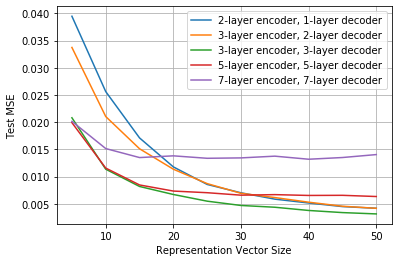

In [29]:
# for idx, test_score in enumerate(test_scores):
#     print(repr_sizes[idx], end=":\t")
#     print('MSE {:.5f}'.format(test_score))
results.pop('group4', None)
for group in list(results.keys()):
    repr_sizes = results[group]["repr_sizes"]
    test_scores = results[group]["test_scores"]

    plt.plot(repr_sizes, test_scores, label=results[group]["model_category"])
# plt.plot(repr_sizes, test_scores, label="Large model")
plt.grid()
plt.legend()
plt.xlabel("Representation Vector Size")
plt.ylabel("Test MSE")
plt.show()

In [13]:
# best_idx = np.argmax([results[group]["test_scores"] for group in list(results.keys())])
# print(best_idx)

In [30]:
# plt.figure(0)
# plt.figure(figsize=(15,5))

# # Plot training accuracy
# plt.subplot(1,2,1)
# for idx, history in enumerate(histories):
#     plt.plot(history.history['loss'], label=f"Train {repr_sizes[idx]}")
#     plt.plot(history.history['val_loss'], label=f"Val {repr_sizes[idx]}")
# plt.title('Training accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(loc='upper left')
# plt.grid()

# # # Plot validation accuracy
# # plt.subplot(1,2,2)
# # for idx, history in enumerate(models_embeddings["histories"]):
# #     plt.plot(history.history['val_accuracy'], label=models_embeddings['names'][idx])
# # plt.title('Validation accuracy')
# # plt.ylabel('Accuracy')
# # plt.xlabel('Epoch')
# # plt.legend(loc='upper left')
# # plt.grid()

And now we check how the reconstructed images look. If you improved the model, they should be better compared to the linear model.

In [61]:
all_scores = np.array([results[group]["test_scores"] for group in results.keys()]).flatten()
idx = np.argmin(all_scores)
group_idx = int(idx/len(results["group1"]["repr_sizes"]))
model_idx = idx % len(results["group1"]["repr_sizes"])

# BEST MODEL
model = results[list(results.keys())[group_idx]]["models"][model_idx]
repr_size = results[list(results.keys())[group_idx]]["repr_sizes"][model_idx]
name = results[list(results.keys())[group_idx]]["model_category"]
mse = results[list(results.keys())[group_idx]]["test_scores"][model_idx]
epochs = results[list(results.keys())[group_idx]]["epochs"][model_idx]
steps = 3
layer_sizes = [[784],
               [784-int((784-repr_size)/steps*n) for n in range(1,steps+1)],
               [784-int((784-repr_size)/steps*n) for n in range(1,steps+1)][::-1],
               [784]]
layer_sizes =  [784]
for x in [784-int((784-repr_size)/steps*n) for n in range(1,steps+1)]:
    layer_sizes.append(x)
for x in [784-int((784-repr_size)/steps*n) for n in range(1,steps+1)][1::-1]:
    layer_sizes.append(x)
layer_sizes.append(784)

print("==== BEST MODEL FOUND ====")
print(f"Model category:                  {name}")
print(f"Representation vector size:      {repr_size}\t(Compression rate {round(100-repr_size/784*100,2)} %)")
print(f"Number of parameters:            {model.count_params()}")
print(f"Epochs of training:              {epochs}")
print(f"Reconstruction error (test MSE): {round(mse,4)}")
print(f"Feature vector sizes:            {layer_sizes}")

==== BEST MODEL FOUND ====
Model category:                  3-layer encoder, 3-layer decoder
Representation vector size:      50	(Compression rate 93.62 %)
Number of parameters:            1197324
Epochs of training:              49
Reconstruction error (test MSE): 0.0031
Feature vector sizes:            [784, 540, 295, 50, 295, 540, 784]


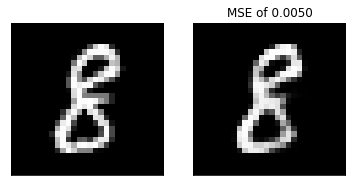

In [74]:
ind = np.random.randint(x_test.shape[0] -  1)
## The function below is defined in the tutorial
plot_recons_original(x_test[ind], y_test[ind], model)

Now we plot the new features we obtained with the designed non-linear model. For the report, use PCA as your dimensionality reduction (needed if the representation layer in your autoencoder has dimensionality > 2), although you can also test the tSNE code below, which is widely used in feature visualization.

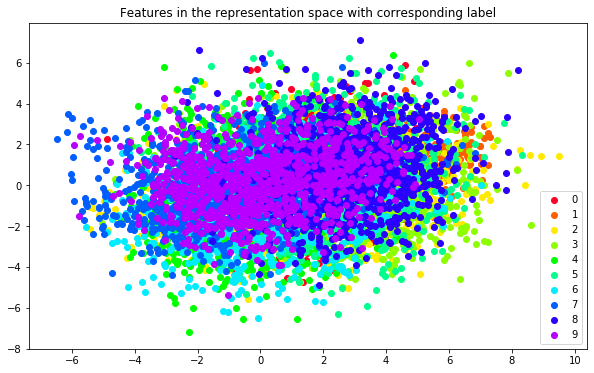

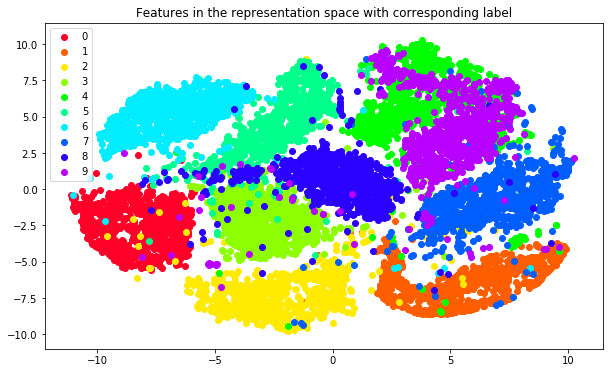

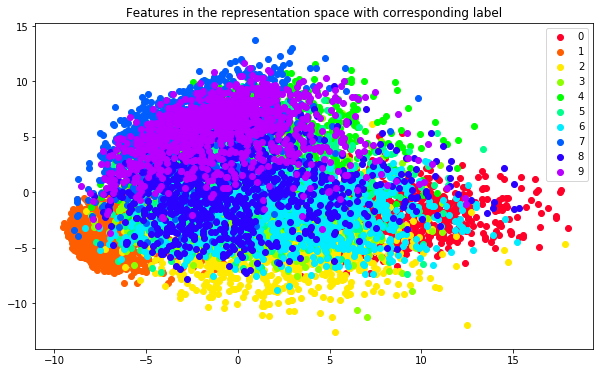

(<Figure size 720x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff27875e4a8>)

In [45]:
## The function below is defined in the tutorial

representation = predict_representation(model, x_test)

tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
representation_tsne = tsne.fit_transform(representation)

# PCA code
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca = pca.fit(predict_representation(model, x_train))
representation_pca = pca.transform(representation)

## The function below is defined in the tutorial
plot_representation_label(representation, y_test)
plot_representation_label(representation_tsne, y_test)
plot_representation_label(representation_pca, y_test)

## Task 2: Custom Loss Functions

Another approach to improve the robustness of the representation created by autoencoders is to replace the quadratic error with a loss function that is more robust to outliers. For instance, we could use Mean Absolute Error (MAE) instead of MSE. 

Sometimes, you need to use a loss function that is not defined in Keras. If that happens, you can define it by yourself and use it into the model.compile module. 

You must define some variables:

* **True values** are those that we are aiming to generate, e.g. GT images.
* **Predicted values** are those that the network has generated,  e.g. denoised images.
* **Loss value** is the computed loss between true and predicted values,  e.g. MSE value.

Let's see an example of how to define a custom loss function:

In [ ]:
def custom_loss(true_values, predicted_values):
  
  loss_value = 0
  
  #     ...    

  #     Define here your loss

  #     ...
    
  return loss_value

Now, an example of how to code and use MSE loss function:

In [ ]:
from keras import backend as K

# Load the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.
x_test /= 255.

num_classes = 100
y_train=to_categorical(y_train,num_classes)
y_test=to_categorical(y_test,num_classes) 

# Add noise
x_train_noise = x_train + np.random.normal(size = x_train.shape, scale = 0.1)
x_test_noise = x_test + np.random.normal(size = x_test.shape, scale = 0.1)

def UNet_model():
  
  inputs = Input((32,32,3))
  
  ## Encoder part
  conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
  drop4 = Dropout(rate=0.5)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

  conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
  drop5 = Dropout(rate=0.5)(conv5)

  ## Now the decoder starts
  up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
  merge6 = concatenate([drop4,up6], axis = 3)
  conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)

  up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)

  up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)

  up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
  conv10 = Conv2D(3, 3,  padding = 'same')(conv9)

  model = Model(inputs = inputs, outputs = conv10)
  
  return model

In [ ]:

def custom_loss(true_values, predicted_values):
    print(predicted_values.shape)
    return K.mean(K.square(predicted_values - true_values), axis=-1)

print("here")
model = UNet_model()
print("yoyo")
model.compile(optimizer = 'Adam', loss = custom_loss, metrics = ['mse'])
print("start training...")
model.fit(x_train_noise, x_train, batch_size=128, epochs=10, validation_split=0.1, verbose=1)

_, mse = model.evaluate(x_test_noise, x_test)

print('MSE (trained with Custom MSE loss): ', mse)

There is a lot of research based on the best loss function to improve the quality of denoised images. Try to use a different loss function and see which one gives you the best result. Some well-known loss functions for image denoising are:

*  Structural Similarity Index ([SSIM](https://en.wikipedia.org/wiki/Structural_similarity))
*  Multiscale Structural Similarity Index ([MS-SSIM](https://ieeexplore.ieee.org/document/1292216?arnumber=1292216&tag=1))
* 1 / [PSNR](https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio)
* L0-norm
* Correntropy
* MSE/MAE



**Report:**
*  In this task you are asked to build a table containing the MSE results on the test split of the models trained with different loss functions. Use at least three different loss functions from the previous list and discuss the differences you observe. You can also report denoised images to support your arguments. 

Use the following code and write your custom loss function within the provided `custom_loss` method.



In [1]:
import warnings
warnings.filterwarnings('ignore')
from keras import backend as K
import numpy as np
import keras
from keras.datasets import cifar100
from keras.utils import to_categorical
from keras.layers import Input, concatenate , Conv2D, Dropout, MaxPooling2D, UpSampling2D
from keras.models import Model
from tqdm import tqdm
from pprint import pprint
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [2]:
# Load the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.
x_test /= 255.

num_classes = 100
y_train=to_categorical(y_train,num_classes)
y_test=to_categorical(y_test,num_classes) 

# Add noise
x_train_noise = x_train + np.random.normal(size = x_train.shape, scale = 0.1)
x_test_noise = x_test + np.random.normal(size = x_test.shape, scale = 0.1)
print(x_train.shape)

(50000, 32, 32, 3)


In [3]:
def UNet_model():
  
  inputs = Input((32,32,3))
  
  ## Encoder part
  conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
  drop4 = Dropout(rate=0.5)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

  conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
  drop5 = Dropout(rate=0.5)(conv5)

  ## Now the decoder starts
  up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
  merge6 = concatenate([drop4,up6], axis = 3)
  conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)

  up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)

  up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)

  up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
  conv10 = Conv2D(3, 3,  padding = 'same')(conv9)

  model = Model(inputs = inputs, outputs = conv10)
  
  return model

In [4]:
# def ssi(true_values, predicted_values):    
#     loss_value = 0
#     return loss_value

# def mssi(true_values, predicted_values):    
#     loss_value = 0
#     return loss_value

# def psnr_inverse(true_values, predicted_values):    
#     def psnr(img1, img2):
#         mse = K.mean( (img1.flatten() - img2.flatten()) ** 2 )
#         if mse == 0:
#             return 100
#         PIXEL_MAX = 1.0
#         return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))
#     loss_value = 0
#     for i in range(true_values.shape[0]):
#         loss_value += 1.0/psnr(true_values[i],predicted_values[i])
#     return -loss_value/true_values.shape[0]

# def l0_norm(true_values, predicted_values):
#     return K.mean(K.cast(K.not_equal(true_values, predicted_values), 'float16'), axis=-1)
# #     return K.sum([1 for x in true_values-predicted_values.flatten() if x != 0.0])/len(true_values)

def correntropy_2(true_values, predicted_values):
    SIGMA = 1e2
    return -K.mean(K.exp(-((true_values - predicted_values))**2/SIGMA),axis=-1)

def correntropy_4(true_values, predicted_values):
    SIGMA = 1e4
    return -K.mean(K.exp(-((true_values - predicted_values))**2/SIGMA),axis=-1)


def correntropy_6(true_values, predicted_values):
    SIGMA = 1e6
    return -K.mean(K.exp(-((true_values - predicted_values))**2/SIGMA),axis=-1)

def mse(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true), axis=-1)

def mae(y_true, y_pred):
    return K.mean(K.abs(y_pred - y_true), axis=-1)

In [5]:
np.random.seed(36)

losses_names = ["Correntropy (sigma 1e2)",
                "Correntropy (sigma 1e4)",
                "Correntropy (sigma 1e6)",
                "MSE",
                "MAE"]


losses = [correntropy_2,correntropy_4,correntropy_6,
          mse,mae ]

test_scores = []
histories = []
models = []
epochs_done = []

epochs = 15

for idx,custom_loss in tqdm(enumerate(losses), total=len(losses)):
    model = UNet_model()
    model.compile(optimizer = 'Adam', loss = custom_loss, metrics = ['mse'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)
    history = model.fit(x_train_noise, x_train, batch_size=128, epochs=epochs, 
                        validation_split=0.1, callbacks=[early_stopping],verbose=0)

    models.append(model)
    histories.append(history)
    epochs_done.append(early_stopping.stopped_epoch if early_stopping.stopped_epoch else epochs)
    
    _, mse = model.evaluate(x_test_noise, x_test, verbose=0) 
#     print(f'MSE (trained with {losses_names[idx]}): ', mse)
    test_scores.append(mse)
    
    
results = {"losses":losses_names,"models":models,
              "histories":histories,"test_scores":test_scores,
              "epochs":epochs_done}

100%|██████████| 5/5 [1:37:20<00:00, 1168.01s/it]


In [6]:
pprint(results)

{'epochs': [15, 9, 5, 15, 15],
 'histories': [<keras.callbacks.callbacks.History object at 0x7f06b40c2ef0>,
 'losses': ['Correntropy (sigma 1e2)',
            'Correntropy (sigma 1e4)',
            'Correntropy (sigma 1e6)',
            'MSE',
            'MAE'],
 'models': [<keras.engine.training.Model object at 0x7f06b7b569b0>,
 'test_scores': [0.001749727874994278,
                 0.0023312808480113745,
                 0.0063408780843019485,
                 0.0018885227618739009,
                 0.0015425055753439665]}


In [15]:
data = {"losses":losses_names,
              "histories":[history.history for history in histories],"test_scores":test_scores,
              "epochs":epochs_done}

In [16]:
import pickle
def save_status(data, dest):
    outfile = open(dest, 'wb') 
    pickle.dump(data, outfile)                       
    outfile.close()
def load_status(f): 
    with open(f, 'rb') as infile:     
        status = pickle.load(infile) 
    return status
picklefile = "checkpoints_07/task2_results"

save_status(data, picklefile)

data= load_status(picklefile)

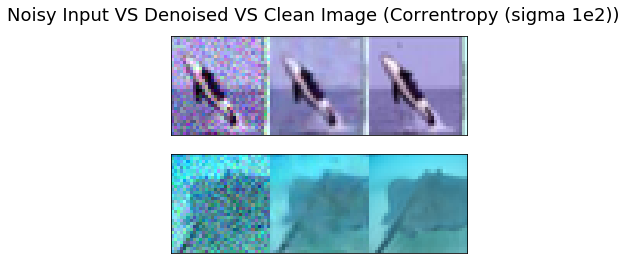

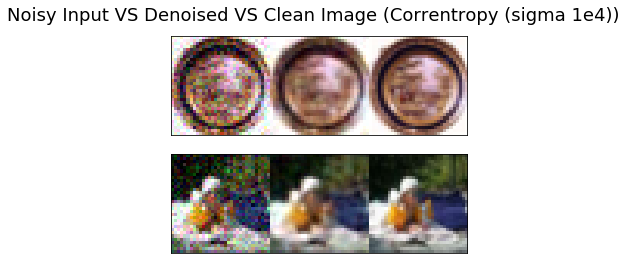

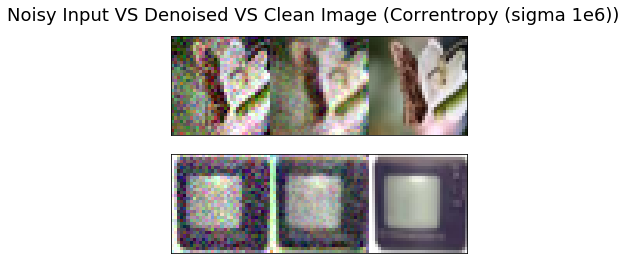

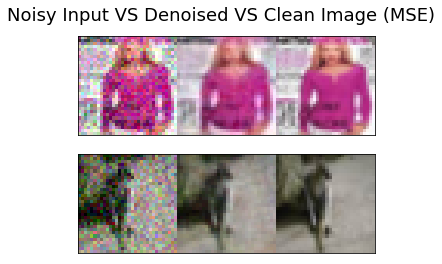

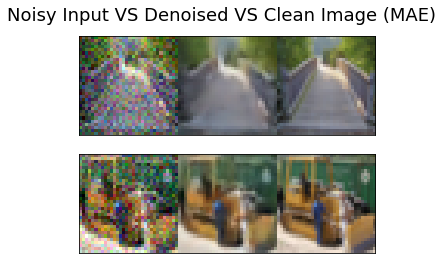

In [10]:
for idx, model in enumerate(results["models"]):
    idx_example = np.random.randint(0, len(x_test_noise))
    x_test_denoised = model.predict(x_test_noise[idx_example:idx_example+2, ...])

    N=2
    start_val = 0 
    fig, axes = plt.subplots(N,1)
    plt.suptitle(f'Noisy Input VS Denoised VS Clean Image ({results["losses"][idx]})', fontsize=18)
    for row in range(N):
      for col in range(1):
        idx = start_val+row+N*col

        im = np.concatenate((x_test_noise[idx_example+idx], x_test_denoised[idx], x_test[idx_example+idx]), 1)
        axes[row].imshow(np.clip(im, 0, 1))
        axes[row].set_xticks([])
        axes[row].set_yticks([])
    fig

<Figure size 432x288 with 0 Axes>

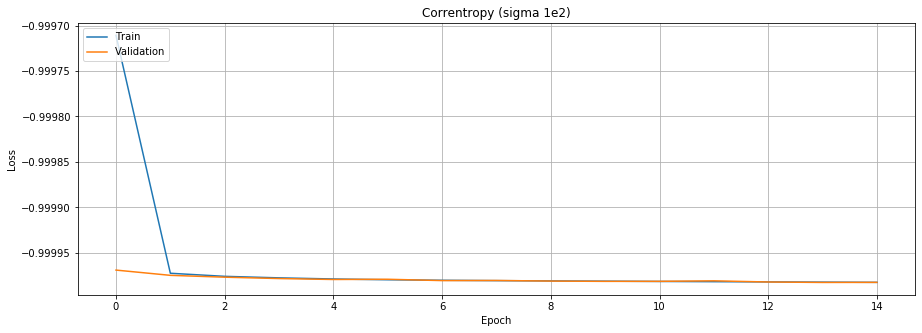

<Figure size 432x288 with 0 Axes>

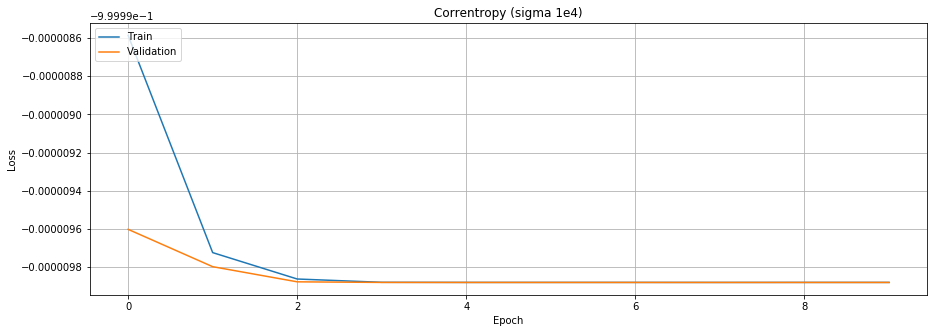

<Figure size 432x288 with 0 Axes>

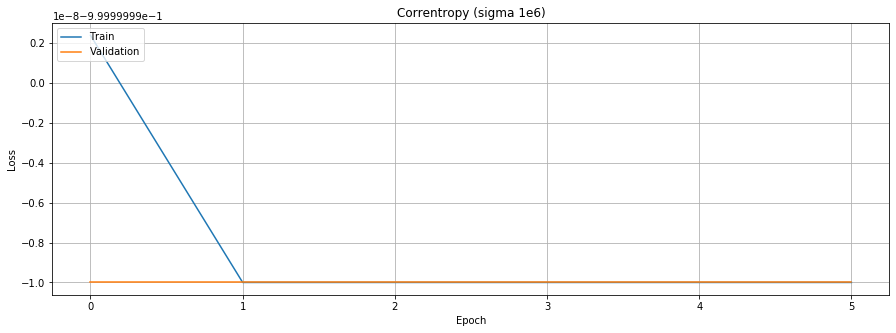

<Figure size 432x288 with 0 Axes>

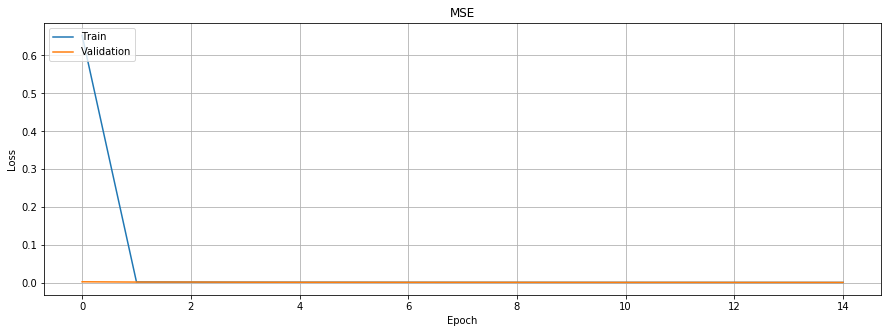

<Figure size 432x288 with 0 Axes>

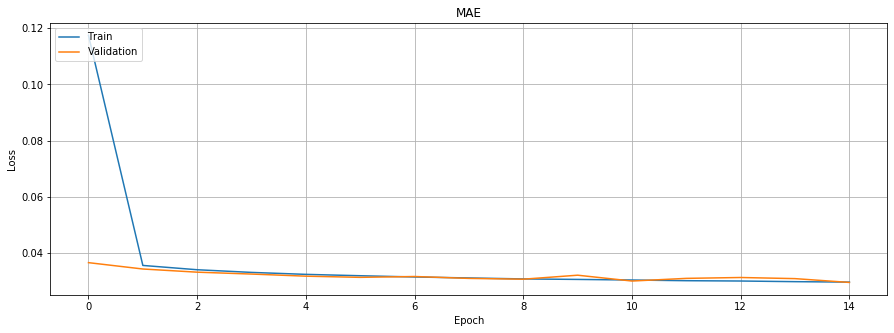

In [27]:
# Plot training/val accuracy
for idx, history in enumerate(data["histories"]):
    plt.figure(idx)
    plt.figure(figsize=(15,5))
    plt.plot(history['loss'], label=f"Train")
    plt.plot(history['val_loss'], label=f"Validation")
    plt.title(f"{data['losses'][idx]}")
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.grid()
    plt.show()

In [29]:
print("==== Test MSE ====")
for idx, test_score in enumerate(data["test_scores"]):
    print(f"{data['losses'][idx]}\t{round(test_score,5)}\t(Epochs: {data['epochs'][idx]})")

==== Test MSE ====
Correntropy (sigma 1e2)	0.00175	(Epochs: 15)
Correntropy (sigma 1e4)	0.00233	(Epochs: 9)
Correntropy (sigma 1e6)	0.00634	(Epochs: 5)
MSE	0.00189	(Epochs: 15)
MAE	0.00154	(Epochs: 15)
